# Goal of Project

Create a variational auto encoder to learn abstract art and then represent it/show newly generated images as a continually changing bases.

The encoder will capture the statistical patterns in the abstract art (downsampling) and the decoder will then upscale the downsampled images based on representation selected from a distribution gathered in the downsampling.

https://keras.io/examples/generative/vae/

In [5]:
#import required modules

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#for image resizing
import cv2 
import glob

#visualization
import matplotlib.pyplot as plt

In [6]:
keras.__version__

'2.3.0-tf'

In [7]:
import tensorflow as tf
tf.__version__

'2.2.0'

## Preprocess Images

Images are downloaded in bulk from unsplash via the node.js module "bulksplash". 
<br>Source: https://github.com/MehediH/Bulksplash

To Do:

- Images same size


In [8]:
#resizing with cv2 and outputting to directory
resize_height = 1080
resize_width = 1920
color_channels = 3

def preprocess_images(resize_height, resize_width, show=False):

    images = []
    counter = 0
    for file in glob.glob('./images/train/*.jpg'):
        print(f"Image {counter}")
        img = cv2.imread(file)
        new_img = cv2.resize(img, (resize_height,resize_width))
        
        if show==True:
            plt.imshow(new_img)
            plt.show()

        plt.imsave(f'./images_processed/train/{counter}.jpg', new_img)
        cv2.waitKey(0)

        #save as np array and add to array
        img_np = np.asarray(new_img)
        images.append(img_np)

        print(f"...complete")
        counter += 1

    #save numpy array to current directory
    np.save('./images_np_array/images_np_array', images)
    
#preprocess_images(resize_height, resize_width, show=False)

# Model

In [9]:
#load the data from disk
data = np.load('./images_np_array/images_np_array.npy')

data.shape

(103, 1080, 1920, 3)

#### Latent Space Sampling Function

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## VAE Encoder Network

In [11]:
latent_dim = 2 #number of dimensions to encode to


In [12]:
encoder_inputs = keras.Input(shape=(resize_height,resize_width, 3))

x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1080, 1920,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 540, 960, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 270, 480, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 8294400)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## VAE Decoder Network

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(270 * 480 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((270, 480, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8294400)           24883200  
_________________________________________________________________
reshape (Reshape)            (None, 270, 480, 64)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 540, 960, 64)      36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 1080, 1920, 32)    18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1080, 1920, 3)     867       
Total params: 24,939,459
Trainable params: 24,939,459
Non-trainable params: 0
_______________________________________________

## VAE as Model with Custom Training

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= resize_height * resize_width
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Training

In [58]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=False)
vae.fit(data, epochs=3, batch_size=1)

Epoch 1/3
103/103 [==============================] - 18s 175ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nans - loss: nan - reconstruction_loss: 
Epoch 2/3
103/103 [==============================] - 18s 173ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan
Epoch 3/3
103/103 [==============================] - 18s 178ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan


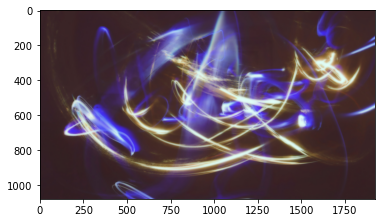

In [59]:
plt.imshow(data[1])

In [70]:
#decoder(encoder(data[1]))
codings = tf.random.normal(shape=[1,latent_dim])
decoded_data = decoder.predict(codings)

In [71]:
codings

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.48032442,  0.29359087]], dtype=float32)>

In [72]:
decoded_data

array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
        

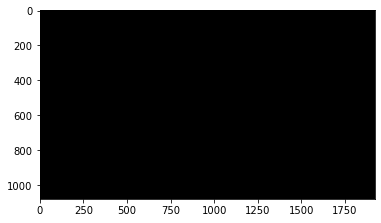

In [64]:
plt.imshow(decoded_data[0])